In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

import seaborn as sns
import plotly.express as px

from scipy import stats
from collections import defaultdict

from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import folium
from folium import plugins

In [2]:
from IPython.core.display import HTML
css = open('Style/style-table.css').read() + open('Style/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
import yaml

doc = open('mapbox/creds.yaml', 'r')
token = yaml.load(doc, Loader=yaml.FullLoader)

# Data loading

> The data here was already checked and cleaned.The whole process and analysis  is available in the [github repo](https://github.com/FernandoMeiraFilho/Edmonton-Library-EDA) with the name of **Edmonton Library - Data Manipulation and Preparation.ipynb.**

#### Library holds Dataset - Main dataset

In [4]:
data = pd.read_csv('library_ranks_prepared.csv')#.iloc[:,7:].drop(['pubdate'], axis=1)
data = data.rename(columns={'genre':'genre2', 'genre_fixed':'genre'}) # getting improved genre column
data = data.drop(['genre2'], axis=1)

#creating holding_year column
data['date'] = pd.to_datetime(data['date'])
data['hold_year'] = data['date'].dt.year

data.head()

,row_id,branch_id,branch_name,holds,title,author,date,url,google_rating,publishing_Date,genre,hold_year
0,EPLLON20150316The girl on the train / Paula Ha...,EPLLON,Londonderry Branch,36,The girl on the train,Hawkins Paula,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,3.5,2015.0,Fiction,2015
1,EPLLON20150316The maze runner / James Dashner,EPLLON,Londonderry Branch,18,The maze runner,Dashner James,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,3.5,2014.0,Juvenile Fiction,2015
2,EPLLON20150316Crash & burn : a novel / Lisa Ga...,EPLLON,Londonderry Branch,17,Crash & burn : a novel,Gardner Lisa,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,4.0,2017.0,Young Adult Fiction,2015
3,EPLLON20150316Gray Mountain / John Grisham,EPLLON,Londonderry Branch,14,Gray Mountain,Grisham John,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,3.5,2014.0,Fiction,2015
4,EPLLON20150316Cambridge IELTS ... : examinatio...,EPLLON,Londonderry Branch,14,Cambridge IELTS ... : examination papers from ...,University of Cambridge Local Examinations Syn...,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,NaN,2002.0,Foreign Language Study,2015


In [5]:
include =['object', 'float', 'int']
data.describe(include = include).fillna(0).loc[['count', 'unique'], :]

,row_id,branch_id,branch_name,holds,title,author,url,google_rating,publishing_Date,genre,hold_year
count,32300,32300,32300,32300.0,32300,32134,32300,23963.0,32300.0,32289,32300.0
unique,32300,22,22,0.0,3312,2375,3414,0.0,0.0,63,0.0


#### branch info Dataset - additional dataset

In [6]:
branch_info = pd.read_csv('branch_info.csv')
branch_info.head()

,Branch ID,Branch,Address,Latitude,Longitude
0,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
1,EPLRIV,Riverbend,"460 Riverbend Square, Rabbit Hill Road & Terwi...",53.468394,-113.583769
2,EPLESQ,Enterprise Square (Downtown),10212 Jasper Avenue NW,53.541194,-113.496835
3,EPLJPL,Jasper Place,9010 - 156 Street,53.523226,-113.590400
4,EPLLHL,Lois Hole (Callingwood),17650 69 Avenue,53.503771,-113.626074


# Data Analysis

### Some questions to solve:

 - Is the total number of holdings growing (or decreasing)?
 - Is there any pattern concerning the published date? 
 - Can we conclude anything using the google books rating?
 - What are the most popular books?
 - Are the popular books popular in all branchs?
 - Are there any patterns concerning the genre of books? what about genre in different branches?
 

### - 'Is the total number of holdings growing (or decreasing)??' 

#### Data availability

First, let's check the data availability for the all the years.

In [7]:
# adding col with the hold_month
data['hold_month'] = data['date'].dt.month

#counting number of months present by year of data presented
holdData = data[['hold_year', 'hold_month']]
holdData_g = holdData.groupby(['hold_year', 'hold_month']).agg(appearances=('hold_month', 'size'))
holdData_g
holdData_g = holdData_g.sort_values(['hold_year', 'hold_month']).reset_index()
holdData_g = holdData_g.groupby(['hold_year']).agg(total_data_points=('appearances', 'sum'),
                                                  number_of_months=('hold_month', 'size')).reset_index()
holdData_g

,hold_year,total_data_points,number_of_months
0,2015,8644,11
1,2016,8709,11
2,2017,6481,9
3,2018,8256,10
4,2019,210,1


**We don't have any years with complete data**. If we take off 2019, 2017 is the year with less data, and 2018 just slightly better.

#### General analysis

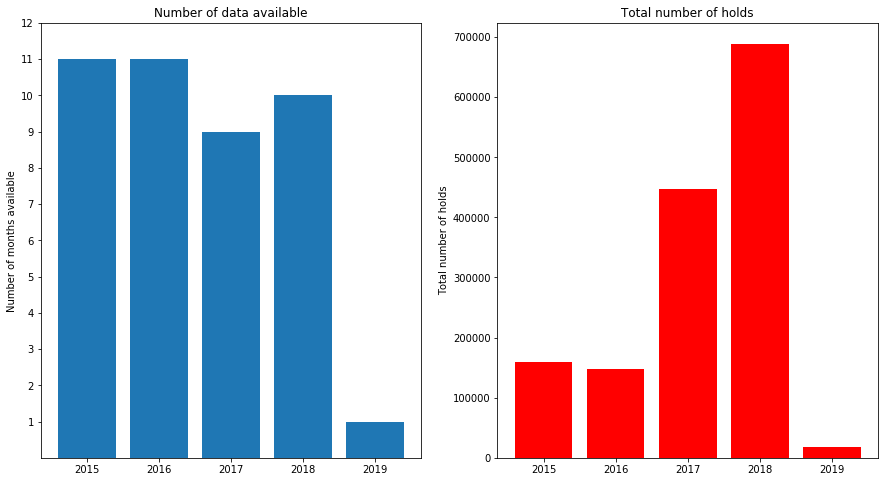

In [8]:
holdTotal = data[['hold_year', 'holds', 'branch_id', 'branch_name']]
hold_g = holdTotal.groupby(['hold_year']).agg(totalHolds=('holds', 'sum')).reset_index()

fig0, ax0 = plt.subplots(1, 2, figsize=(15,8))

ax0[0].bar(holdData_g.hold_year, holdData_g.number_of_months)
ax0[0].set_ylabel('Number of months available')
ax0[0].title.set_text('Number of data available')
ax0[0].set_yticks(list(range(1,13)))
ax0[1].bar(hold_g.hold_year, hold_g.totalHolds, color='red')
ax0[1].set_ylabel('Total number of holds')
ax0[1].title.set_text('Total number of holds')

Interesting points:

**2017 and 2018 show evolution in the total number of holds** even though we know we have incomplete data, and that this exact years have less data than 2015 and 2016.

#### Branch analysis

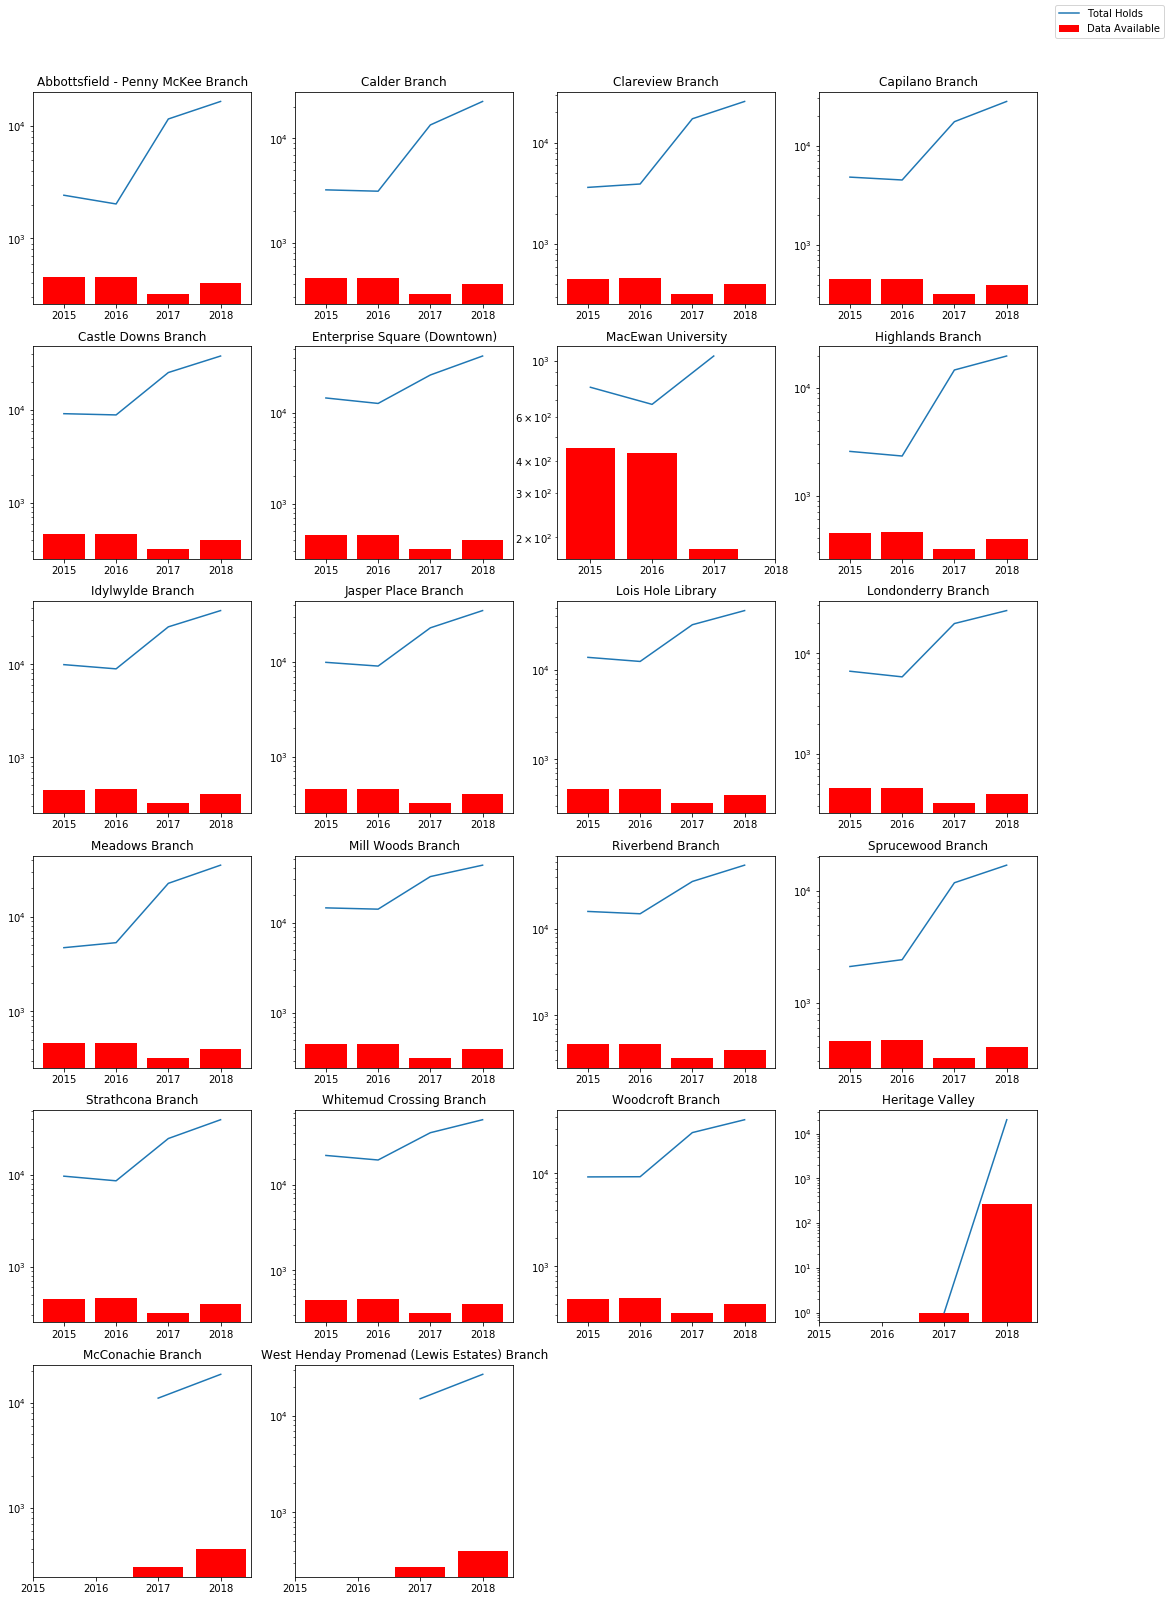

In [9]:
holdbranch = holdTotal.groupby(['hold_year', 'branch_id', 'branch_name']).agg(total_holds=('holds', 'sum'),
                                                                        data_available=('hold_year', 'size'))
holdbranch = holdbranch.reset_index()
holdbranch = holdbranch[holdbranch.hold_year != 2019]

years = [2015, 2016, 2017, 2018] # lets leave 019 once that it is an incomplete year - informartion wise
branches = list(holdbranch.branch_name.unique())

ncol = 4
nrow = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(18,25))

row = 0
col = 0
for count,branch in zip(range(ncol*nrow),branches): 
    if col == 4:
        col = 0
        row+=1
    hb = holdbranch[holdbranch.branch_name==branch]
    ax[row,col].plot(hb.hold_year, hb.total_holds, label='Total Holds')
    ax[row,col].bar(hb.hold_year, hb.data_available, log=True, color='red', label='Data Available')
    ax[row,col].title.set_text(branch)
    ax[row,col].set_xticks(years)
    
    col += 1

fig.legend(labels=['Total Holds', 'Data Available'], loc='upper right')
plt.subplots_adjust(top=0.95)
plt.title('Number of holds per year - per branch')

ax[-1,-1].set_visible(False)
ax[-1,-2].set_visible(False)

Some interesting points to observe:

- In the majority of the branches, even though we have less data in the years of 2017 and 2018, we still have a growing number of total holds
- The branches where we have only 2017 and 2018 of data (maybe newer branches or newer to this dataset data collection) , we have the number of holds seems to follow the bigger availability of data.

### - 'Is there any pattern concerning the published date?' 

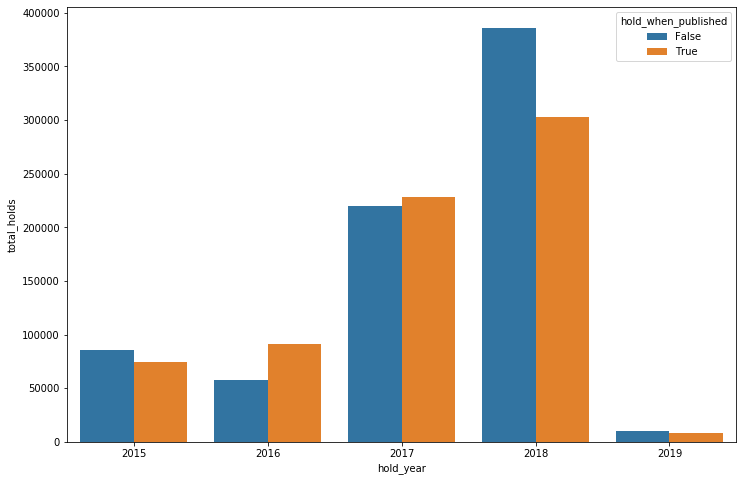

In [10]:
pubs = data.loc[:, ['branch_id', 'branch_name', 'holds', 'hold_year', 'publishing_Date']]
pubs.loc[:,'hold_when_published'] = pubs.hold_year == pubs.publishing_Date

pubs_g = pubs.groupby(['hold_year', 'hold_when_published']).agg(total_holds=('holds', 'sum'))
pubs_g = pubs_g.reset_index()

sns.barplot(x='hold_year', y='total_holds', hue='hold_when_published', data=pubs_g)

It seems that novelty is a trend that comes and goes. It was ignited in 2016 and 2017, but in 2018 the preference went back to books published in previous years, rather than brand published books.

Let's try to see the picture branch wise:

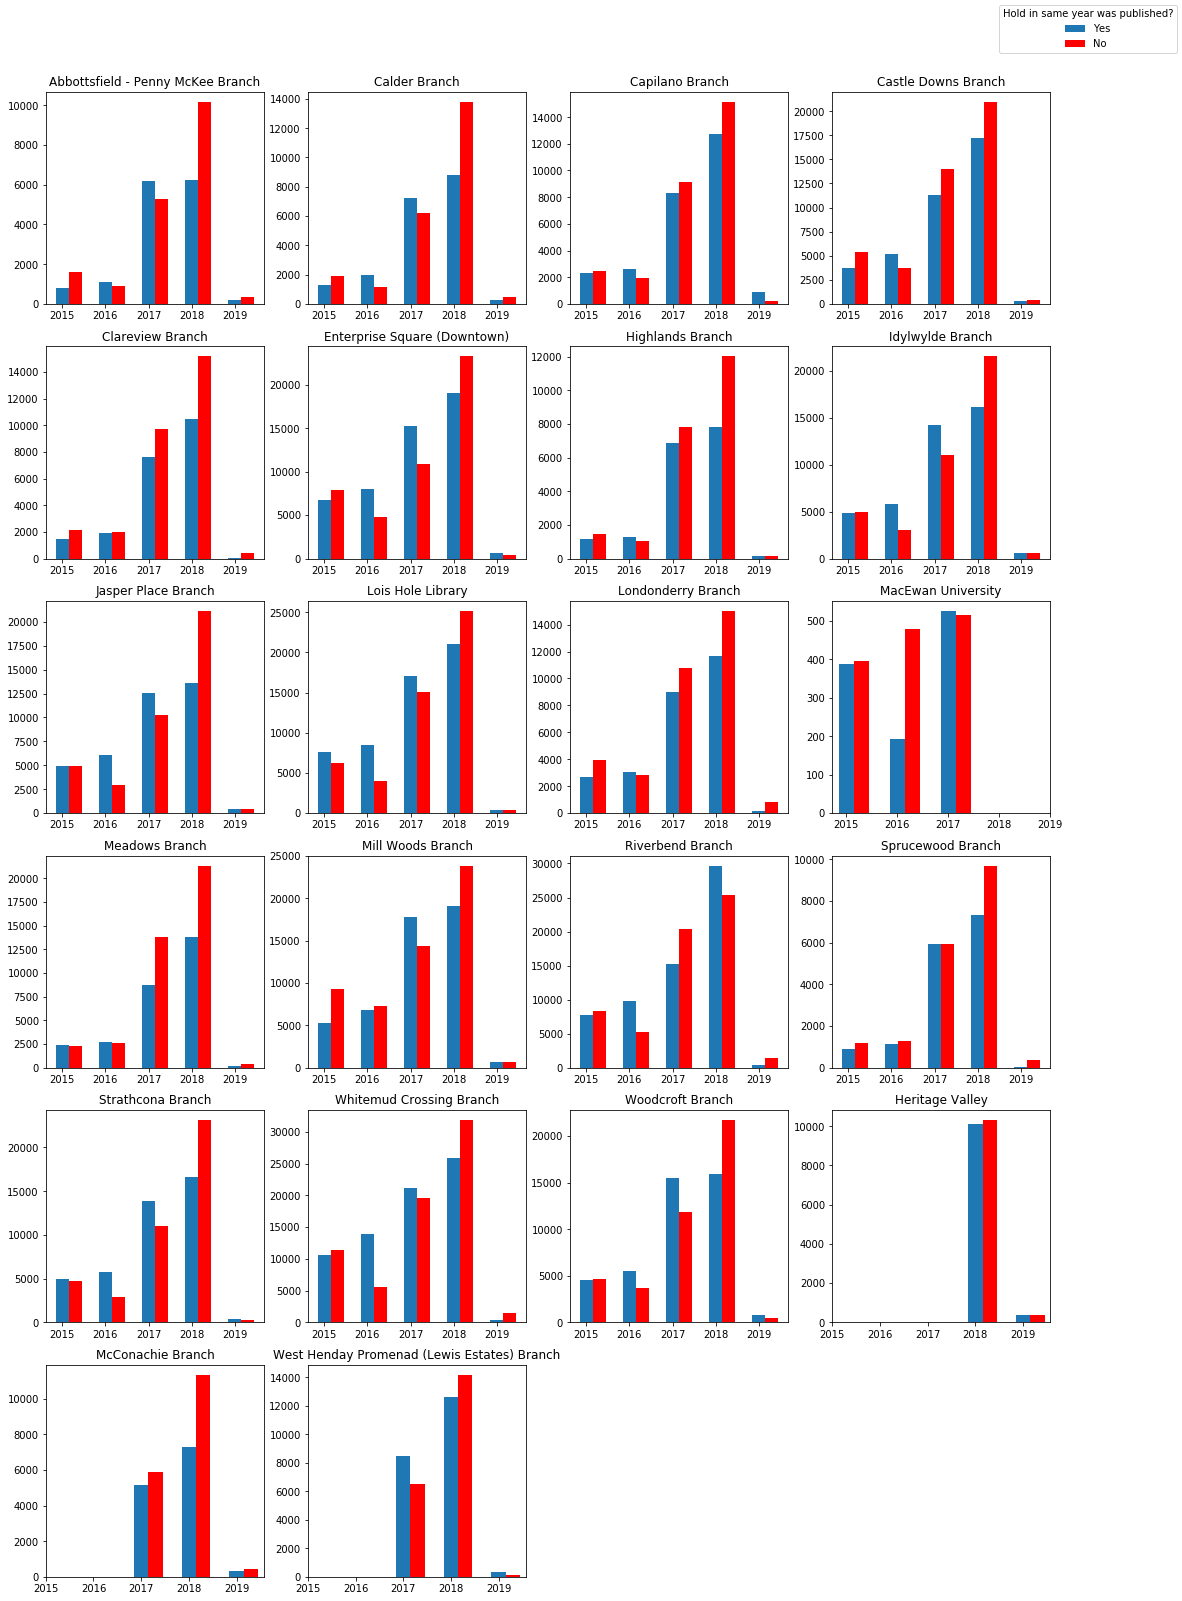

In [11]:
pubs_gb = pubs.groupby(['hold_year', 'branch_name', 'hold_when_published']).agg(total_holds=('holds', 'sum'))

pubs_gb = pubs_gb.reset_index()

years = [2015, 2016, 2017, 2018, 2019] # lets leave 019 once that it is an incomplete year - informartion wise
branches = list(pubs_gb.branch_name.unique())

ncol = 4
nrow = 6
fig2, ax2 = plt.subplots(nrow, ncol, figsize=(18,25))

width = 0.3
row = 0
col = 0
for count,branch in zip(range(ncol*nrow),branches): 
    if col == 4:
        col = 0
        row+=1
    hb = pubs_gb[pubs_gb.branch_name==branch]
    hb_t = hb[hb.hold_when_published == True]
    hb_f = hb[hb.hold_when_published == False]
    ax2[row,col].bar(hb_t.hold_year, hb_t.total_holds,width, label='True')
    ax2[row,col].bar(hb_f.hold_year+width, hb_f.total_holds,width, color='red', label='False')
    ax2[row,col].title.set_text(branch)
    ax2[row,col].set_xticks(years)
    col += 1
                    
fig2.legend(labels=['Yes', 'No'], loc='upper right', title='Hold in same year was published?' )
plt.subplots_adjust(top=0.95)
plt.title('Number of holds per year - per branch')

ax2[-1,-1].set_visible(False)
ax2[-1,-2].set_visible(False)

We can see that there are branches trending towards recent published books, while others are trending in the other way - or even oscillating between the two.

#### All time geo exploration

In [12]:
pub_geototal = pubs.groupby(['branch_id','hold_when_published']).agg(total_holds=('holds', 'sum'))
pub_geototal.loc[:,'%_holds'] = 0
pub_geototal.loc[:,'publishing_preference'] = ''

#create dataset with newer, neutral, older labels
brchs = list(pub_geototal.index.unique('branch_id'))
boo = [True, False]
for branch in brchs:
    branch_total = pub_geototal.loc[branch,'total_holds'].sum()
    for bol in boo:
        val = pub_geototal.loc[(branch,bol), 'total_holds']
        pub_geototal.loc[(branch,bol),'%_holds'] = val/branch_total
    
    # for a certain bias tower newer or older I was initially looking for values >= than 0.60
    # but it seems we cannot conclude anything for this case so we are going to use 0.55
    
    true_p = pub_geototal.loc[(branch,True), '%_holds']
    if true_p >= 0.55:
        pub_geototal.loc[(branch,True),'publishing_preference'] = 'Newer'
    elif true_p>0.45 and true_p<0.55:
        pub_geototal.loc[(branch,True),'publishing_preference'] = 'Neutral'
    else:
        pub_geototal.loc[(branch,True),'publishing_preference'] = 'Older'
        
pub_geototal = pub_geototal[pub_geototal['publishing_preference']!=''].reset_index()

#merge de coordinates
pub_geomerged = pub_geototal.merge(branch_info, how='left', left_on='branch_id', right_on='Branch ID')

#plot graph

# marker_c = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
#             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
#             'darkpurple', 'pink', 'lightblue', 'lightgreen', 
#             'gray', 'black', 'lightgray']

pub_colors = {
    'Newer': 'blue',
    'Neutral': 'gray',
    'Older': 'red'
}

m_pub = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

for index, row in pub_geomerged.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                                    radius = 10,
                                    color = 'gray',
                                    fill=True,
                                    fill_opacity=0.9,
                                    fill_color=pub_colors[row['publishing_preference']],
                                    tooltip= row['Branch'],
                                   ).add_to(m_pub)

legend_html_pub =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            &nbsp; Newer &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                            &nbsp; Neutral &nbsp; <i class="fa fa-map-marker fa-2x" style="color:gray"></i><br>
                            &nbsp; Older &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                              </i>
                </div>
                ''' 

m_pub.get_root().html.add_child(folium.Element(legend_html_pub))
m_pub

What about during the years?

In [13]:
# Crafting the dataset with years
pub_geoyear = pubs.groupby(['hold_year', 'branch_id','hold_when_published']).agg(total_holds=('holds', 'sum'))
pub_geoyear.loc[:,'%_holds'] = 0
pub_geoyear.loc[:,'publishing_preference'] = ''

#create dataset with newer, neutral, older labels
brchs2 = list(pub_geoyear.index.unique('branch_id'))
years_p = list(pub_geoyear.index.unique('hold_year'))
boo = [True, False]

for year in years_p:
    for branch in brchs2:
        try:
            branch_total = pub_geoyear.loc[(year,branch),'total_holds'].sum()
            for bol in boo:
                val = pub_geoyear.loc[(year,branch,bol), 'total_holds']
                pub_geoyear.loc[(year,branch,bol),'%_holds'] = val/branch_total

            # for a certain bias tower newer or older lets try 60% minimum

            true_p = pub_geoyear.loc[(year,branch,True), '%_holds']
            if true_p >= 0.6:
                pub_geoyear.loc[(year, branch,True),'publishing_preference'] = 'Newer'
            elif true_p>0.4 and true_p<0.6:
                pub_geoyear.loc[(year, branch,True),'publishing_preference'] = 'Neutral'
            else:
                pub_geoyear.loc[(year, branch,True),'publishing_preference'] = 'Older'
        except KeyError:
            continue
pub_geoyear = pub_geoyear[pub_geoyear['publishing_preference']!=''].reset_index()

pub_geoyear

#merge de coordinates
pub_geoyear_m = pub_geoyear.merge(branch_info, how='left', left_on='branch_id', right_on='Branch ID')
pub_geoyear_m.head()

,hold_year,branch_id,hold_when_published,total_holds,%_holds,publishing_preference,Branch ID,Branch,Address,Latitude,Longitude
0,2015,EPLABB,True,812,0.335676,Older,EPLABB,Abbottsfield - Penny McKee,3410 - 118 Avenue,53.570451,-113.391518
1,2015,EPLCAL,True,1318,0.410592,Neutral,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
2,2015,EPLCLV,True,1472,0.404729,Neutral,EPLCLV,Clareview,3808 - 139 Avenue,53.601302,-113.401769
3,2015,EPLCPL,True,2329,0.482594,Neutral,EPLCPL,Capilano,9915 - 67 Street,53.537896,-113.419927
4,2015,EPLCSD,True,3753,0.410792,Neutral,EPLCSD,Castle Downs,"106 Lakeside Landing, 15379 Castle Downs Rd",53.615736,-113.516633


In [14]:
@interact(year = widgets.IntSlider(min=2015, max=2019, step=1, value=2015))
def generate_geo_pub(year=[2015, 2016, 2017, 2018, 2019]):
    '''Generate Geo Map with round markers with publishing proference in each branch
       Represents sucesses by year in number of hold
       
       year = integer, year you would like to analyze
        '''
    m_pub_y = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    data_pub = pub_geoyear_m[pub_geoyear_m.hold_year==year]
    
    for index, row in data_pub.iterrows():
        folium.CircleMarker([row['Latitude'], row['Longitude']],
                                    radius = 10,
                                    color = 'gray',
                                    fill=True,
                                    fill_opacity=0.9,
                                    fill_color=pub_colors[row['publishing_preference']],
                                    tooltip= row['Branch'],
                                   ).add_to(m_pub_y)

    legend_html_pub =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            &nbsp; Newer &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                            &nbsp; Neutral &nbsp; <i class="fa fa-map-marker fa-2x" style="color:gray"></i><br>
                            &nbsp; Older &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                              </i>
                </div>
                ''' 

    m_pub_y.get_root().html.add_child(folium.Element(legend_html_pub))
    
    return m_pub_y   

interactive(children=(IntSlider(value=2015, description='year', max=2019, min=2015), Output()), _dom_classes=(…

Overall I would not say that the publishing dates have a profound influence in the **all time total amounts of holdings**, once that the %s are close to 55-45%, which are not very satisfactory  to take any conclusion.

Looking the yearly fluctuations we seem to have quite the same scenario, although in 2018 we see a more prominent trend towards oldest books than newest ones.

### - 'Can we conclude anything using the google books rating??' 

As I could seen and the data preparation phase (in another notebook, check the [github](https://github.com/FernandoMeiraFilho/Edmonton-Library-EDA) if you want to see it), the google rating info is missing in approximately 25% of the lines of the dataset. 

Let's check if this affect a bigger part of the holds -so it would compromise out capacity to take some conclusion using this information - .

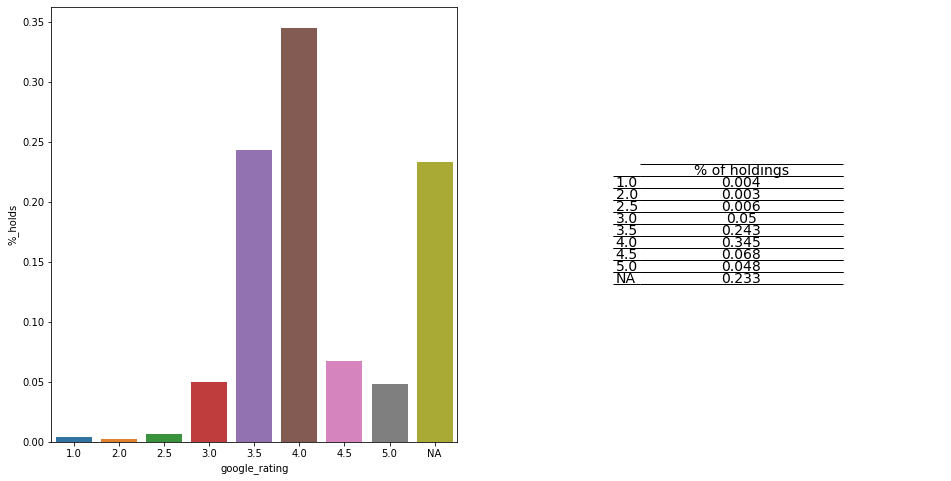

In [15]:
grating = data.loc[:,['hold_year', 'holds', 'google_rating']].fillna('NA')
grating_g = grating.groupby(['google_rating']).agg(total_holds=('holds', 'sum'))
grating_g['%_holds'] = grating_g.loc[:,'total_holds'] / grating_g.loc[:,'total_holds'].sum()
grating_g = grating_g.reset_index()#.sort_values('%_holds')

figR, axR = plt.subplots(1,2, figsize=(16,8))

ratings = list(grating_g.google_rating.unique())
rlabel = [str(rat) for rat in ratings]
vals = [[str(round(value,3))] for index,value in grating_g['%_holds'].iteritems()]

sns.barplot(x='google_rating', y='%_holds', data=grating_g, ax=axR[0])
axR[1].axis('tight')
axR[1].axis('off')
axR[1].table(cellText=vals, rowLabels=rlabel, colLabels=['% of holdings'],loc='center', 
             cellLoc='center', colWidths=[0.5], edges='horizontal').set_fontsize(14)


So, as we could see concerning the number of lines, the scenario here for the number of holds ins quite the same. We have **23%** of the number of holds with NA values.

Anyway, it is interesting to note that the bulk of the holdings are gravitating towards the 3.5 and 4.0 rating. 

### The size effect

Before we dig into the study of the successes, let's understand more the dynamics of the branch size - in holding power.


In [16]:
size = data.loc[:,['branch_name', 'holds', 'hold_year']]
size_g = size.groupby(['branch_name','hold_year']).agg(total_holds=('holds', 'sum'))
size_g = size_g.unstack(1).fillna(0)

#creating total columns
size_g['total_sum'] = size_g.sum(axis=1)
size_g['total_mean'] = size_g.mean(axis=1)
size_g['total_median'] = size_g.median(axis=1)

#creating size rank column
nbs = len(size_g.index)
size_g = size_g.sort_values('total_sum')
size_g['size_rank'] = sorted(list(range(1,nbs+1)))
size_g = size_g.sort_values('total_sum', ascending=False)

size_g

total_holds                    \
hold_year                                          2015     2016     2017   
branch_name                                                                 
Whitemud Crossing Branch                        22039.0  19493.0  40650.0   
Riverbend Branch                                16007.0  15045.0  35626.0   
Lois Hole Library                               13834.0  12447.0  32087.0   
Mill Woods Branch                               14534.0  14065.0  32192.0   
Enterprise Square (Downtown)                    14603.0  12716.0  26129.0   
Woodcroft Branch                                 9156.0   9198.0  27392.0   
Strathcona Branch                                9687.0   8629.0  24838.0   
Idylwylde Branch                                 9904.0   8924.0  25215.0   
Castle Downs Branch                              9136.0   8860.0  25342.0   
Jasper Place Branch                              9885.0   9028.0  22878.0   
Meadows Branch                                   4701.0   5311.0  22528.0   
Londonderry Branch                               6637.0   5833.0  19813.0   
Capilano Branch                                  4826.0   4516.0  17419.0   
Clareview Branch                                 3637.0   3928.0  17307.0   
Calder Branch                                    3210.0   3116.0  13457.0   
West Henday Promenad (Lewis Estates) Branch         0.0      0.0  14962.0   
Highlands Branch                                 2576.0   2333.0  14698.0   
Sprucewood Branch                                2108.0   2427.0  11843.0   
Abbottsfield - Penny McKee Branch                2419.0   2024.0  11474.0   
McConachie Branch                                   0.0      0.0  11036.0   
Heritage Valley                                     0.0      0.0      1.0   
MacEwan University                                784.0    671.0   1042.0   

                                                             total_sum  \
hold_year                                       2018    2019             
branch_name                                                              
Whitemud Crossing Branch                     57659.0  1873.0  141714.0   
Riverbend Branch                             55065.0  1908.0  123651.0   
Lois Hole Library                            46196.0   787.0  105351.0   
Mill Woods Branch                            43035.0  1253.0  105079.0   
Enterprise Square (Downtown)                 42247.0  1021.0   96716.0   
Woodcroft Branch                             37638.0  1205.0   84589.0   
Strathcona Branch                            39725.0   569.0   83448.0   
Idylwylde Branch                             37693.0  1102.0   82838.0   
Castle Downs Branch                          38171.0   753.0   82262.0   
Jasper Place Branch                          34788.0   846.0   77425.0   
Meadows Branch                               35078.0   549.0   68167.0   
Londonderry Branch                           26666.0  1014.0   59963.0   
Capilano Branch                              27842.0  1113.0   55716.0   
Clareview Branch                             25657.0   503.0   51032.0   
Calder Branch                                22604.0   723.0   43110.0   
West Henday Promenad (Lewis Estates) Branch  26787.0   486.0   42235.0   
Highlands Branch                             19825.0   339.0   39771.0   
Sprucewood Branch                            17015.0   428.0   33821.0   
Abbottsfield - Penny McKee Branch            16415.0   546.0   32878.0   
McConachie Branch                            18622.0   733.0   30391.0   
Heritage Valley                              20393.0   765.0   21159.0   
MacEwan University                               0.0     0.0    2497.0   

                                               total_mean  total_median  \
hold_year                                                                 
branch_name                                                               
Whitemud Crossing Branch                  

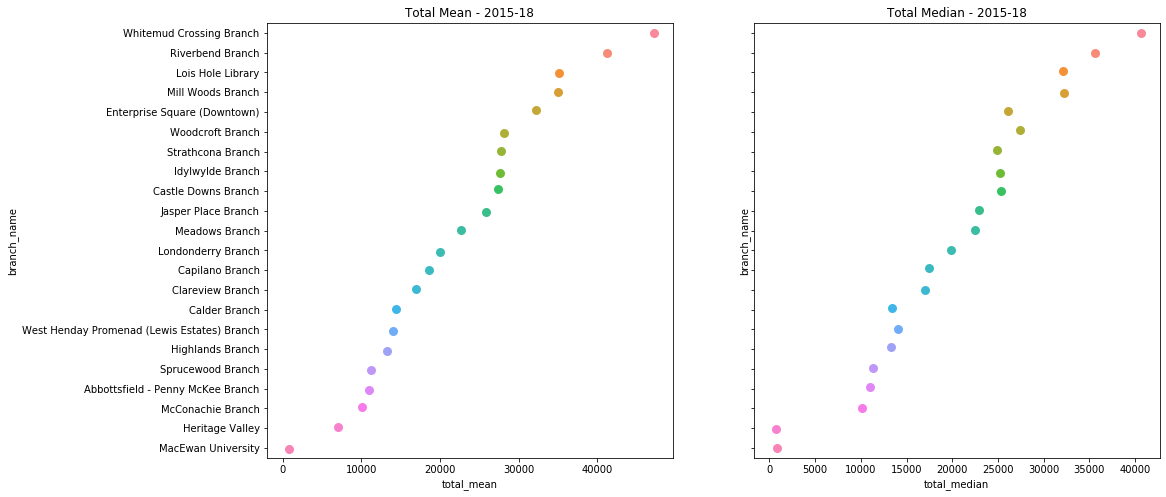

In [17]:
fig4, ax4 = plt.subplots(1,2, figsize=(16,8), sharey=True)

sns.stripplot(x=size_g['total_mean'], y=size_g.index,size=9, ax=ax4[0])
ax4[0].title.set_text('Total Mean - 2015-18')
sns.stripplot(x=size_g['total_median'], y=size_g.index,size=9, ax=ax4[1])
ax4[1].title.set_text('Total Median - 2015-18')

p-value for normatest : 0.7909546661512719


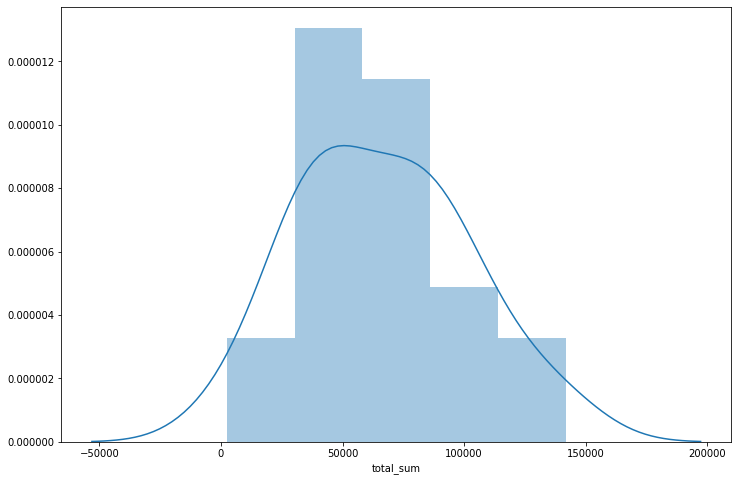

In [18]:
t, p_hold = stats.kurtosistest(size_g['total_sum'], axis=None)

print('p-value for normatest : {}'.format(p_hold))

sns.distplot(size_g['total_sum'])

Even though the distribution for the total holds is not normal (as the kurtosis test indicates), we have can say that we don't have an extreme skewed situation so it would effects our futures analysis further along, but it should be healthy to keep an eye and plot comparisons or use branch ranks to see a possible influention by bigger branches.

### Exploring Genres

First things first, what are our all time champions for genre?

In [19]:
genr = data.loc[:,['genre', 'holds', 'hold_year', 'branch_name']]
genr_g = genr.groupby('genre').agg(total_holds=('holds','sum')).sort_values('total_holds', ascending=False)

#getting total percentages
total = genr_g.loc[:,'total_holds'].sum()
genr_g['%total'] = (genr_g['total_holds']/total)*100

#taking a look at the top 10
print('Top 10 genres % in total holdings:{}'.format(genr_g['%total'].head(10).sum()))
genr_g.head(10)

Top 10 genres % in total holdings:86.94077614233355


,total_holds,%total
genre,,
Fiction,783369,53.537665
Juvenile Fiction,103957,7.104717
Biography & Autobiography,100739,6.884790
Cooking,70164,4.795207
Self-Help,56262,3.845105
Young Adult Fiction,45478,3.108096
Psychology,34363,2.348465
House & Home,27254,1.862616
Business,25324,1.730714


 86% for the top 10! That is total domination(shout out to Fiction that, if we sum up wi 'Juvenile fiction' it is 60% of all holding). Can we see here if this was true for all the years? Is there something new coming?

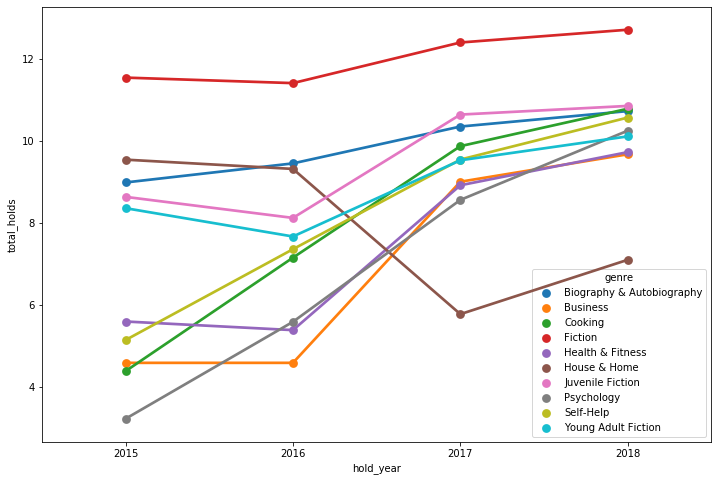

In [20]:
genr_y = genr[genr.hold_year!=2019].groupby(['hold_year','genre']).agg(total_holds=('holds','sum')).reset_index()

top10g = genr_g.index.tolist()[:10]
gen10y = genr_y[genr_y.genre.isin(top10g)]

gen10y
sns.pointplot(x=gen10y.hold_year, y=np.log(gen10y.total_holds), hue=gen10y.genre, log=True )
# plt.xticks([2015,2016,2017,2018])

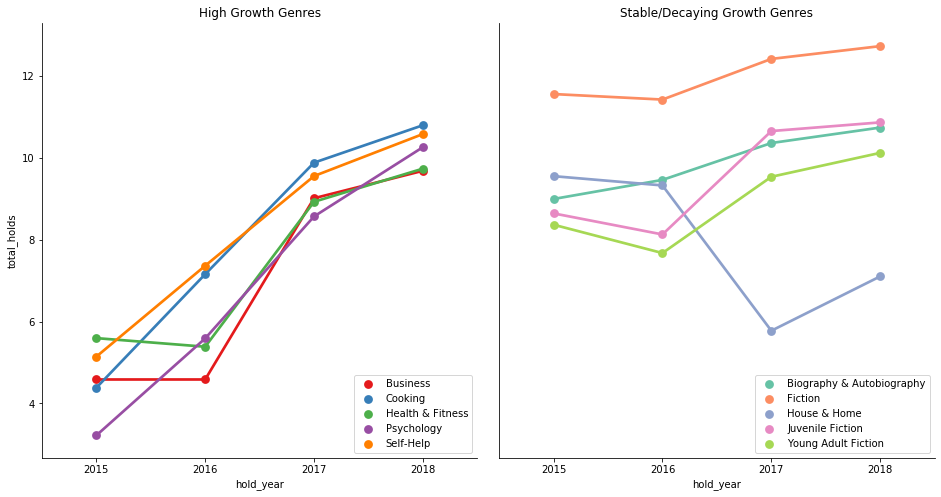

In [21]:
# separating the high growth and the stable genres in 2 plots

high_growth = ['Psychology', 'Business', 'Health & Fitness', 'Cooking', 'Self-Help']
stable_growth = [gen for gen in top10g if gen not in high_growth ]
h_set = genr_y[genr_y.genre.isin(high_growth)]
s_set = genr_y[genr_y.genre.isin(stable_growth)]

figG, axG = plt.subplots(1,2, figsize=(16,8), sharey=True)

sns.set_palette('Set1')
sns.pointplot(x=h_set.hold_year, y=np.log(h_set.total_holds), hue=h_set.genre, ax=axG[0] )
axG[0].title.set_text('High Growth Genres')
axG[0].legend(loc='lower right')

sns.set_palette("Set2")
sns.pointplot(x=s_set.hold_year, y=np.log(s_set.total_holds), hue=s_set.genre, pallete='GnBu_d', ax=axG[1], )
axG[1].title.set_text('Stable/Decaying Growth Genres')
axG[1].get_yaxis().set_visible(False)
axG[1].legend(loc='lower right')

plt.subplots_adjust(wspace=0.05)
sns.despine()

So we have very interesting growth for the high growth genres, and for the stable ones, we can observe that the majority were able to sustain their high level with the exception of the House and Home - that we will investigate further in this analysis.

Is this **high growth genres** being featured in all branches? 

In [22]:
# subplot with heatmaps for each high growth - Using number of holding size rank to ordenate them
gen_heat = genr[genr.hold_year!=2019].groupby(['hold_year', 'branch_name', 'genre']).agg(total_holds=('holds', 'sum'))
gen_heat = gen_heat.reset_index('genre')

#Creating columns with % by year by branch by genre
yearsHeat = [2015, 2016, 2017, 2018]
branchHeat = genr.branch_name.unique().tolist()

gen_heat['%holds'] = 0
for year in yearsHeat:
    for branch in branchHeat:
        try:
            total = gen_heat.loc[(year,branch),'total_holds'].sum()
            gen_heat.loc[(year, branch),'%holds'] =  (gen_heat.loc[(year, branch),'total_holds'] / total)*100
        except KeyError:
            continue

gen_heat = gen_heat.reset_index()

#bringing the size_rank to check for the big branches effect
srank_dt = size_g.loc[:,['size_rank']].reset_index().stack().reset_index().drop(['level_0','hold_year'], axis=1)
gen_heat = gen_heat.merge(srank_dt, how='left', on='branch_name')
gen_heat = gen_heat.sort_values(['hold_year', 'size_rank'], ascending=False)

#Cleaning branch names to make them smaller
gen_heat['branch_name'] = gen_heat['branch_name'].apply(lambda name: name.replace(' Branch', ''))
gen_heat['branch_name'] = gen_heat['branch_name'].apply(lambda name: name.split(' (')[0])

# Creating new name to contain rank for the graphs
rnk_dt = gen_heat.loc[:,['branch_name', 'size_rank']].drop_duplicates(['branch_name'])
rank_dict = { row['branch_name']:row['size_rank'] for index, row in rnk_dt.iterrows() }
                 
gen_heat['branch-rank'] = gen_heat.branch_name.apply(lambda branch:'Rank {} - {}'.format(
                                                                                    rank_dict[branch], branch))

gen_heat.head()

,hold_year,branch_name,genre,total_holds,%holds,size_rank,branch-rank
1678,2018,Whitemud Crossing,Art,227,0.393694,22,Rank 22 - Whitemud Crossing
1679,2018,Whitemud Crossing,Biography & Autobiography,5581,9.679322,22,Rank 22 - Whitemud Crossing
1680,2018,Whitemud Crossing,"Body, Mind & Spirit",223,0.386757,22,Rank 22 - Whitemud Crossing
1681,2018,Whitemud Crossing,Business,521,0.903588,22,Rank 22 - Whitemud Crossing
1682,2018,Whitemud Crossing,Cooking,4427,7.677899,22,Rank 22 - Whitemud Crossing


In [23]:
genres_heat = sorted(gen_heat.genre.unique().tolist())

@interact
def generate_heatsns(genre = genres_heat):

    heater = gen_heat[gen_heat.genre==genre]#.sort_values
    heater_piv= heater.pivot_table(index=['size_rank', 'branch-rank'], values='%holds', columns='hold_year')
    heater_piv= heater_piv.fillna(0).sort_values('size_rank', ascending=False)
    heater_piv = heater_piv.reset_index('size_rank').drop('size_rank', axis=1)

    plt.title('HeatMap - Genre Adoption by Branch by Year')
    
    return sns.heatmap(heater_piv, annot=True, cmap="YlGnBu")

interactive(children=(Dropdown(description='genre', options=('Architecture', 'Art', 'Automobile driving', 'Bio…

In [24]:
#lets try subplots to see all at once

#fixing the fucntion to generate the plots
def generate_heatmap_genre(genre, ax):
    '''
    generates a heatmap by branch and year
    genre=string
    ax = ax subplot instance
    '''

    heater = gen_heat[gen_heat.genre==genre]#.sort_values
    heater_piv= heater.pivot_table(index=['size_rank', 'branch-rank'], values='%holds', columns='hold_year')
    heater_piv= heater_piv.fillna(0).sort_values('size_rank', ascending=False)
    heater_piv = heater_piv.reset_index('size_rank').drop('size_rank', axis=1)

    ax.set_title(genre,fontweight="bold", size=25)
    ax.tick_params(labelsize=17)
    return sns.heatmap(heater_piv, annot=True, cmap="YlGnBu", ax=ax), 

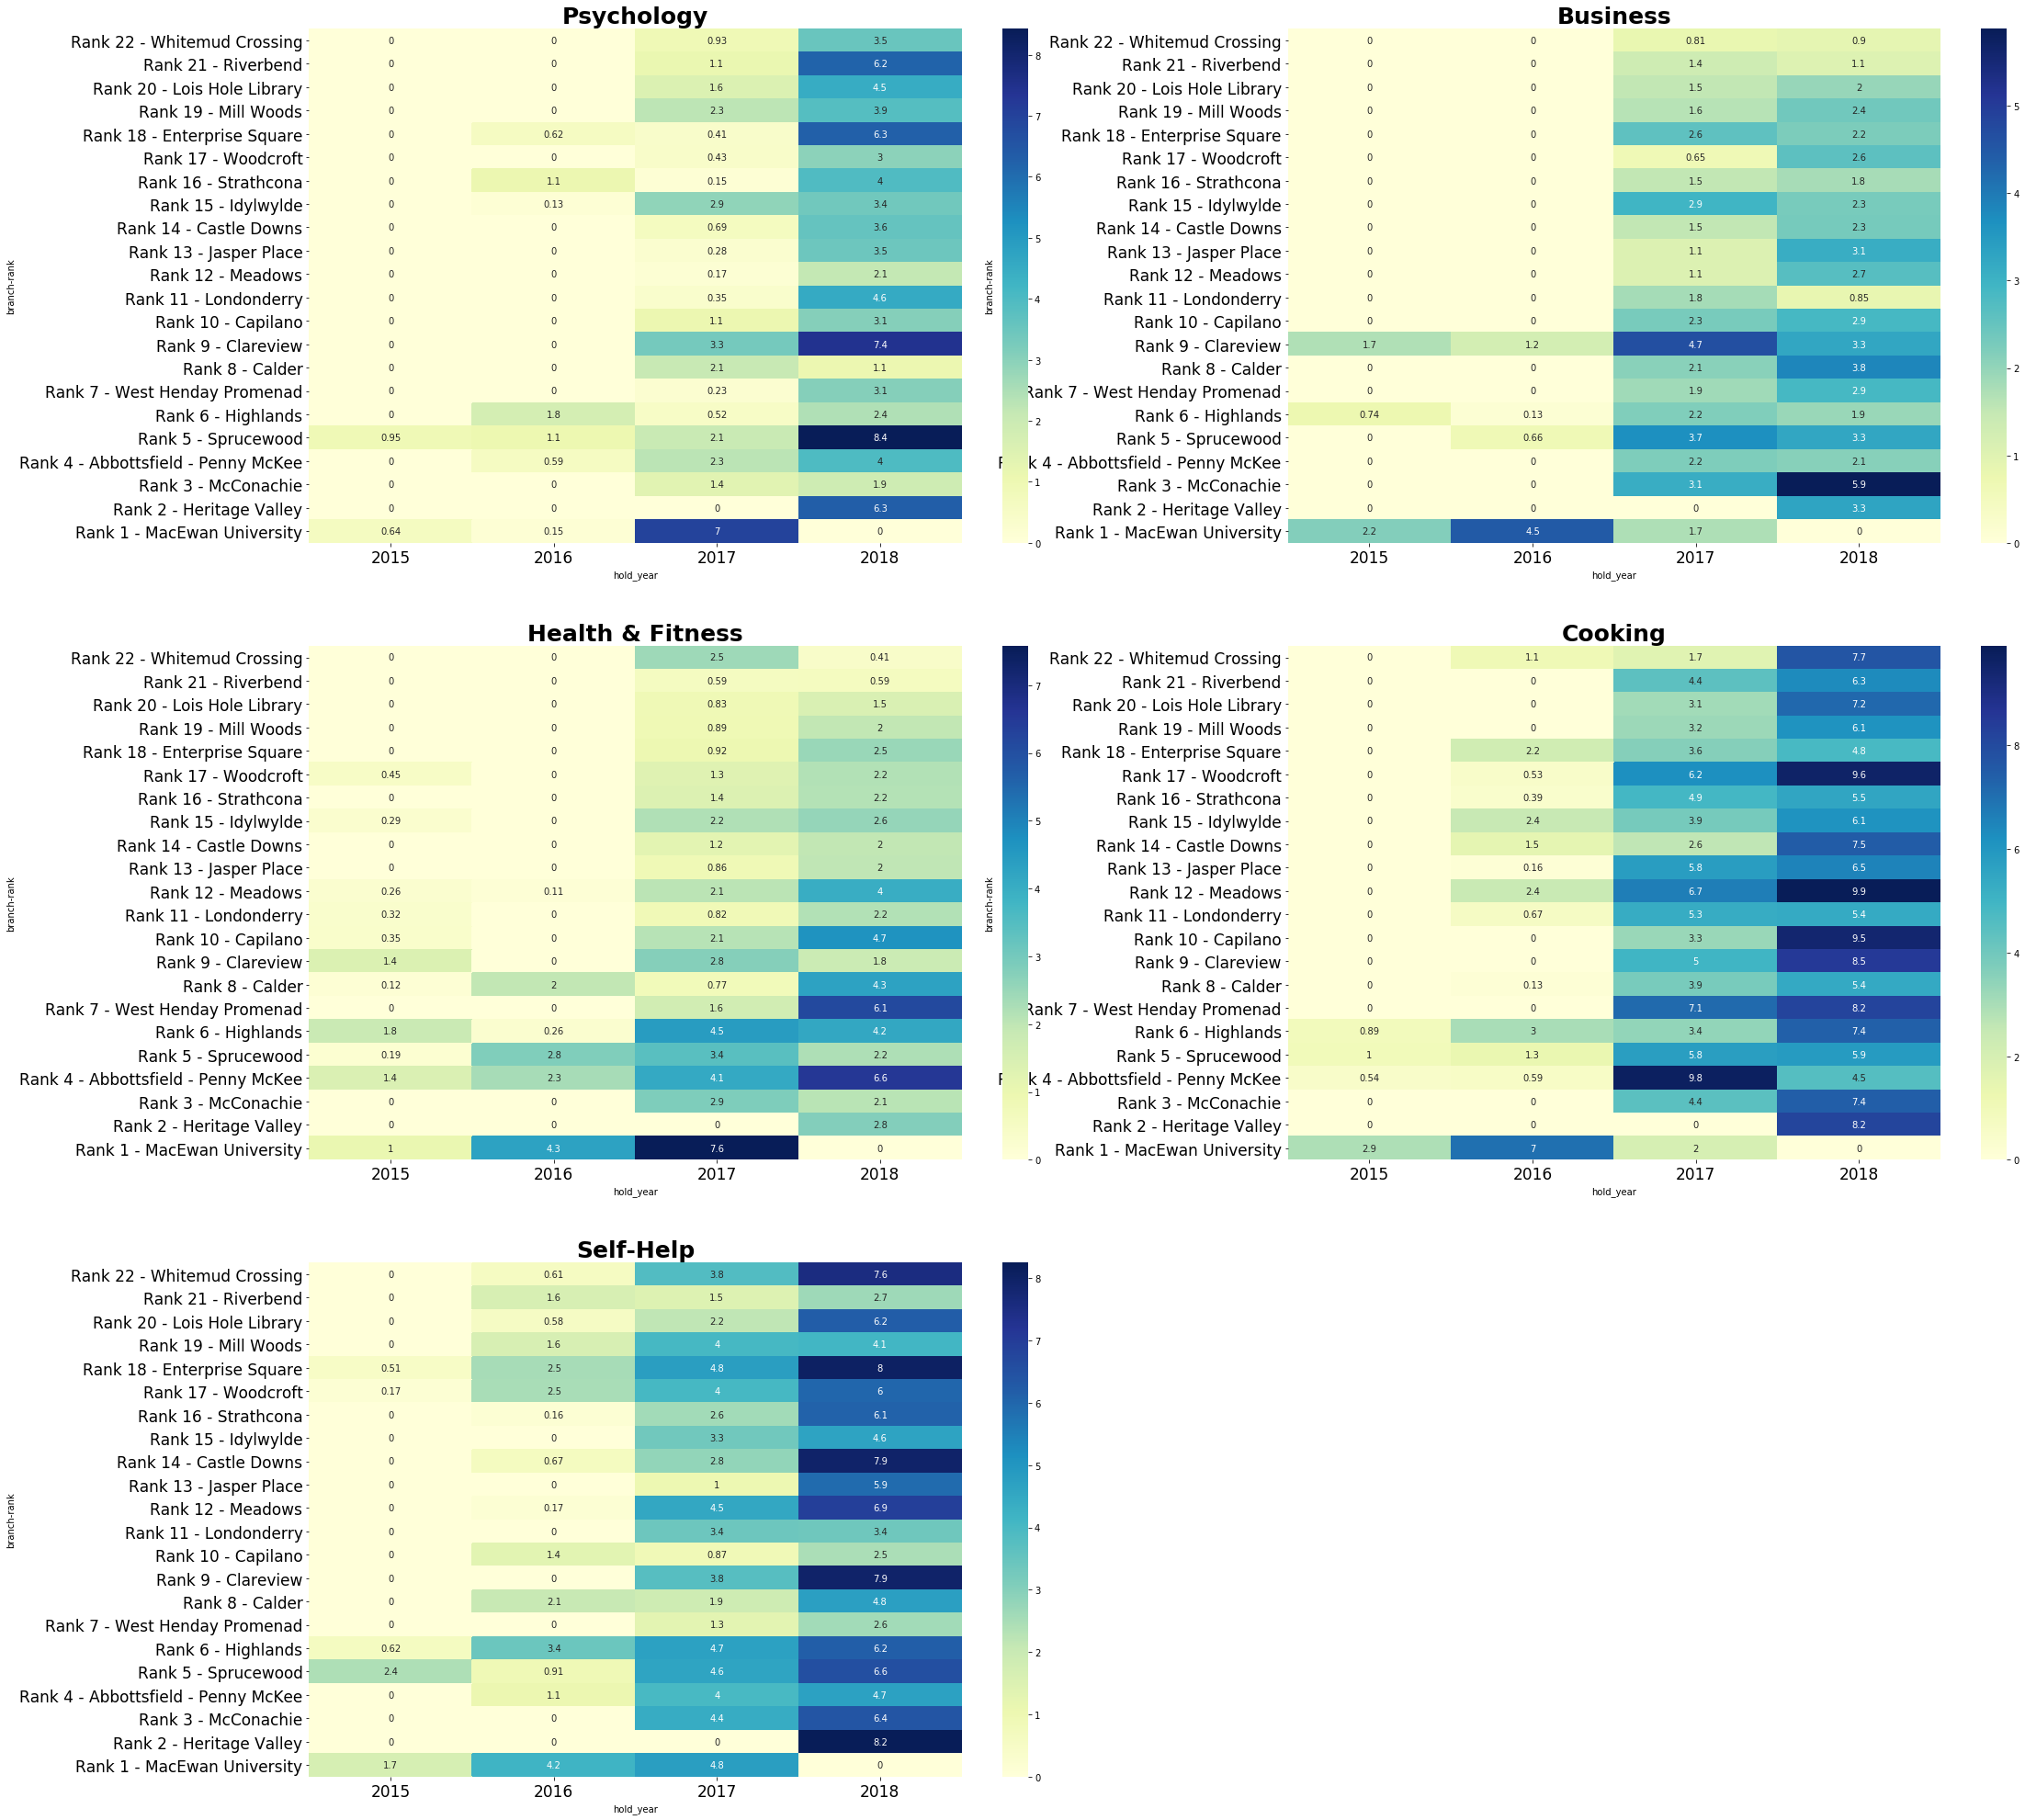

In [25]:
fig5, ax5 = plt.subplots(3,2, figsize=(35,35))

rowH = 0
colH = 0
for genre in high_growth:
    if colH>1:
        colH = 0
        rowH += 1
    generate_heatmap_genre(genre,ax5[rowH,colH])
    colH += 1

ax5[-1, -1].set_visible(False)
plt.title('% Representation of the genre by branch and year')
plt.savefig('heatsub.png')

Are there any particular books responsible for this?

In [26]:
#lets work the data to answer the question
gen_titles = data.loc[:, ['title', 'author', 'hold_year', 'holds', 'genre']]
gen_titles = gen_titles.groupby(['hold_year', 'genre', 'title']).agg(total_hold=('holds', 'sum'))
gen_titles = gen_titles.reset_index('title')

#creating the % column
genresT = list({ genr[1] for genr in gen_titles.index.unique()})
yearT = [2015, 2016, 2017, 2018]

gen_titles.loc[:,'%holds'] = 0
for year in yearT:
    for genre in genresT:
        try:
            total = gen_titles.loc[(year,genre),'total_hold'].sum()
            gen_titles.loc[(year,genre),'%holds'] = (gen_titles.loc[(year,genre),'total_hold'] / total) * 100
        except KeyError:
            continue

gen_titles = gen_titles.reset_index()
gen_titles.head()

,hold_year,genre,title,total_hold,%holds
0,2015,Biography & Autobiography,A house in the sky : a memoir,14,0.174346
1,2015,Biography & Autobiography,Alan Turing : the enigma,545,6.787049
2,2015,Biography & Autobiography,American sniper : the autobiography of the mos...,196,2.440847
3,2015,Biography & Autobiography,Autobiography of a Yogi,9,0.112080
4,2015,Biography & Autobiography,Down the rabbit hole : curious adventures and ...,319,3.972603


In [27]:
# plotly scatter by year and hold number for each genre

@interact
def generate_scatter(genre=sorted(genresT)):
    scat_dt = gen_titles[gen_titles.genre==genre].sort_values('%holds', ascending=False)
    
    #getting some subtitles off the titles to make them smaller
    scat_dt['title'] = scat_dt['title'].apply(lambda title: title.split(':')[0])
    
    #Creating a dict for the top annotations
    top_annots = defaultdict()
    yearS = gen_titles.hold_year.unique().tolist()
    
    for year in yearS:
        try:
            content = defaultdict()
            trans_dt = scat_dt[scat_dt.hold_year==year].iloc[:1,:]
            content['title'] = trans_dt['title'].values[0]
            content['%holds'] = trans_dt['%holds'].values[0]
            content['total_hold'] = trans_dt['total_hold'].values[0]
            content['year'] = trans_dt['hold_year'].values[0]
            top_annots[year] = content
        except IndexError:
            continue
                                                            
    s1 = sns.scatterplot(x='hold_year', y='%holds', size='total_hold', data=scat_dt)
    
    #making the annottions
    for key, value in top_annots.items():
        text = '{}, {}%'.format(value['title'], round(value['%holds'],0))
        s1.text(value['year']+0.1, value['%holds'], text, horizontalalignment='left', size='medium', 
                                                                    color='black', weight='semibold')
                                                               
    sns.despine()
    plt.xticks([2015, 2016, 2017, 2018, 2019])
    return s1

interactive(children=(Dropdown(description='genre', options=('Architecture', 'Art', 'Automobile driving', 'Bio…

What happened to House & Home? 
R: Marie Kondo lost popularity


##### Exploring genre patterns geographically

In [28]:
#getting the addresses of the branches 
brcInfo = pd.read_csv('Public_Libraries.csv')
keep_columns = ['Branch ID', 'Branch', 'Address', 'Latitude', 'Longitude']
brcInfo = brcInfo[keep_columns]

brcInfo.sort_values('Branch ID').head()

,Branch ID,Branch,Address,Latitude,Longitude
7,EPLABB,Abbottsfield - Penny McKee,3410 - 118 Avenue,53.570451,-113.391518
20,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
12,EPLCLV,Clareview,3808 - 139 Avenue,53.601302,-113.401769
14,EPLCPL,Capilano,9915 - 67 Street,53.537896,-113.419927
11,EPLCSD,Castle Downs,"106 Lakeside Landing, 15379 Castle Downs Rd",53.615736,-113.516633


In [29]:
#Creating the data frame by branch and genre to start exploring
g = data.loc[:,['branch_id', 'date', 'genre', 'holds']]
g.loc[:,'date'] = pd.to_datetime(g['date'])
g.loc[:,'hold_year'] = g.date.dt.year

# merging
g_group = g.groupby(['hold_year', 'branch_id', 'genre']).sum().sort_values(['hold_year', 'branch_id', 'holds'], ascending=False)
g_group = g_group.reset_index()
g_merged = g_group.merge(brcInfo, right_on='Branch ID', left_on='branch_id').set_index('hold_year')
g_merged.head()

,branch_id,genre,holds,Branch ID,Branch,Address,Latitude,Longitude
hold_year,,,,,,,,
2019,EPLWOO,Fiction,590,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Biography & Autobiography,294,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Young Adult Fiction,244,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Cooking,77,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2018,EPLWOO,Fiction,19915,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864


In [30]:
#geting the most popular genre per branch, per year considering number of holds

# building the dict for the job!
branch_ids = g_merged.branch_id.unique().tolist()
years = [2015, 2016, 2017, 2018]

master_dict = {}

for year in years:
    master_content = {}
    base = g_merged.loc[year, ['genre','holds', 'branch_id', 'Latitude', 'Longitude', 'Branch']]
    for branch in branch_ids:
        inside_content = {}
        try:
            inside_content['Branch'] = base[base.branch_id == branch].iloc[0,]['Branch']
            inside_content['genre'] = base[base.branch_id == branch].iloc[0,]['genre']
            inside_content['holds'] = base[base.branch_id == branch].iloc[0,]['holds']
            inside_content['Latitude'] = base[base.branch_id == branch].iloc[0,]['Latitude']
            inside_content['Longitude'] = base[base.branch_id == branch].iloc[0,]['Longitude']
            master_content[branch] = inside_content
        except:
            continue
        
    master_dict[year] = master_content

In [31]:
# normalization function - for the marker size 

def normalize(number, upper=20, lower=1):
    normalized = ((number -lower)/(upper - lower)) * 10 
    return int(normalized+9) # +6 to make small numbers more visible in the map

# colors for markers
marker_c = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
            'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
            'darkpurple', 'pink', 'lightblue', 'lightgreen', 
            'gray', 'black', 'lightgray']


In [32]:
#base map
m = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

#Generating the color of the markers
np.random.seed(5)
top_genre = set()
for key, value in master_dict.items():
    for key2, value2 in value.items():
        top_genre.add(value2['genre'])
    
genre_color = {genre:marker_c[np.random.randint(0,len(marker_c)-1)] for genre in top_genre}

@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def generate_geo_genre(year=[2015, 2016, 2017, 2018]):
    '''Generate Geo Map with round markers with the size of number of holds per genre in each branch
       Represents all time sucesses in number of holds
       
       year = integer, year you would like to analyze
        '''
    
    m = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    #Generating the color of the markers
    np.random.seed(1)
    top_genres = {values['genre'] for key,values in master_dict[year].items()}
    genre_color_checking = {genre:genre_color[genre] for genre in top_genres}
    
    #seting up parameters for the marker size
    hold_list = [value['holds'] for key,value in master_dict[year].items() ]
    maxH, minH = max(hold_list), min(hold_list)

    for branch, values in master_dict[year].items():
        folium.CircleMarker([values['Latitude'], values['Longitude']],
                                radius = normalize(values['holds'], maxH, minH),
                                popup = [values['genre']],
                                color = 'gray',
                                fill=True,
                                fill_opacity=0.9,
                                fill_color=genre_color[values['genre']],
                                tooltip= values['Branch'],
                               ).add_to(m)
        
    #generate legends snipets
    snipets = []
    for key, value in genre_color_checking.items():
        snipets.append(
            '&nbsp; {} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{}"></i>'.format(
                                                                                        key, value)
        )
    legend_entries = '<br>'.join(snipets)
        
        
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            {}
                              </i>
                </div>
                '''.format(legend_entries) 

    m.get_root().html.add_child(folium.Element(legend_html))
    m.get_root().html.add_child(folium.Element(year_html))
    print('Predominant Genre in number of all time holdings by branch')
    
    return m

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

> Millwoods resisted the Fiction domination, but it was just a matter of time.. 

Lets try **taking off Fiction** to see other predominant Genres 

In [33]:
#geting the most popular genre per branch, per year considering number of holds

# building the dict for the job!
branch_ids = g_merged.branch_id.unique().tolist()
years = [2015, 2016, 2017, 2018]

g_merged_wf = g_merged[g_merged.genre != 'Fiction'] # Taking off Fiction

master_dict2 = {}

for year in years:
    master_content = {}
    base = g_merged_wf.loc[year, ['genre','holds', 'branch_id', 'Latitude', 'Longitude', 'Branch']]
    for branch in branch_ids:
        inside_content = {}
        try:
            inside_content['Branch'] = base[base.branch_id == branch].iloc[0,]['Branch']
            inside_content['genre'] = base[base.branch_id == branch].iloc[0,]['genre']
            inside_content['holds'] = base[base.branch_id == branch].iloc[0,]['holds']
            inside_content['Latitude'] = base[base.branch_id == branch].iloc[0,]['Latitude']
            inside_content['Longitude'] = base[base.branch_id == branch].iloc[0,]['Longitude']
            master_content[branch] = inside_content
        except:
            continue
        
    master_dict2[year] = master_content

In [34]:
#base map
m2 = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

#Generating the color of the markers
np.random.seed(15)
top_genre2 = set()
for key, value in master_dict2.items():
    for key2, value2 in value.items():
        top_genre2.add(value2['genre'])
    
genre_color2 = {genre:marker_c[np.random.randint(0,len(marker_c)-1)] for genre in top_genre2}

# Running it without fiction
@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def generate_geo_genre(year=[2015, 2016, 2017, 2018]):
    '''Generate Geo Map with round markers with the size of number of holds per genre in each branch
       Represents all time sucesses in number of holds
       
       year = integer, year you would like to analyze
        '''
    
    m2 = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    #checking which markers should appear
    top_genres = {values['genre'] for key,values in master_dict2[year].items()}
    genre_color_check = {genre:genre_color2[genre] for genre in top_genres}
    
    
    #seting up parameters for the marker size
    hold_list = [value['holds'] for key,value in master_dict[year].items() ]
    maxH, minH = max(hold_list), min(hold_list)

    for branch, values in master_dict2[year].items():
        folium.CircleMarker([values['Latitude'], values['Longitude']],
                                radius = normalize(values['holds'], maxH, minH),
                                popup = [values['genre']],
                                color = 'grey',
                                fill=True,
                                fill_opacity=0.9,
                                fill_color=genre_color2[values['genre']],
                                tooltip= values['Branch'],
                               ).add_to(m2)
        
    #generate legends snipets
    snipets = []
    for key, value in genre_color_check.items():
        snipets.append(
            '&nbsp; {} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{}"></i>'.format(
                                                                                        key, value)
        )
    legend_entries = '<br>'.join(snipets)
        
        
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b>Map Legend</b> <br>
                            {}
                              </i>
                </div>
                '''.format(legend_entries) 

    m2.get_root().html.add_child(folium.Element(legend_html))
    m2.get_root().html.add_child(folium.Element(year_html))
    print('Predominant Genre in number of all time holdings by branch - WITHOUT FICTION')
    
    return m2

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

### Exploring HeatMaps

##### Variety HeatMap - Areas with more diversity of genres in the top 10s

In [35]:
#Creating the data frame by branch and genre to start exploring
h = data.loc[:,['branch_id', 'date', 'genre']]
h.loc[:,'date'] = pd.to_datetime(h['date'])
h.loc[:,'hold_year'] = h.date.dt.year

h_group = h.groupby(['hold_year', 'branch_id', 'genre']).agg(genre_count=('genre', 'size'))
h_group = h_group.sort_values(['hold_year', 'branch_id', 'genre_count'], ascending=False).reset_index()

#merging to get coordinates
h_merged = h_group.merge(brcInfo, right_on='Branch ID', left_on='branch_id')#.set_index('hold_year')
h_merged.head()

,hold_year,branch_id,genre,genre_count,Branch ID,Branch,Address,Latitude,Longitude
0,2019,EPLWOO,Fiction,5,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
1,2019,EPLWOO,Biography & Autobiography,2,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2,2019,EPLWOO,Young Adult Fiction,2,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
3,2019,EPLWOO,Cooking,1,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
4,2018,EPLWOO,Fiction,208,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864


In [36]:
# Variety of rankings heatmap

# building the dataframe
i = h_merged
i_group = i.groupby(['hold_year', 'branch_id', 'Latitude', 'Longitude']).agg(number_of_genres=('genre','size'))
i_group = i_group.reset_index()

@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def diversity_heatmap(year=[2015, 2016, 2017, 2018]):

    m3 = folium.Map(location=[53.531611, -113.513975], zoom_start=9.4)
    
    heat_dt = i_group[i_group.hold_year == year]
    heat_dt['weight'] = heat_dt.loc[:,'number_of_genres'] / heat_dt.loc[:,'number_of_genres'].sum()
    
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    params = heat_dt.loc[:,['Latitude', 'Longitude', 'weight']].values
    m3.get_root().html.add_child(folium.Element(year_html))
    m3.add_child(plugins.HeatMap(params, radius=15))
    
    print( 'Regions with more variety of genres in the top 10s')
    return m3

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

##### Genre Intensity by area during years - number of apperances in the top 10

In [37]:
# Variety of rankings heatmap

# building the dataframe
heat_gen = h_merged.groupby(['hold_year','branch_id', 'Latitude', 'Longitude', 'genre']).agg(
                                                                            genre_count=('genre_count', 'sum'))

hbranchs = list(h_merged.branch_id.unique())
hyears = [2015, 2016, 2017, 2018]

heat_gen = heat_gen.reset_index(['Latitude', 'Longitude', 'genre'])
heat_gen['%genre'] = 0

for year in hyears:
    for branch in hbranchs:
        try:
            total = heat_gen.loc[(year,branch), 'genre_count'].sum() 
            heat_gen.loc[(year,branch), '%genre'] = heat_gen.loc[(year,branch), 'genre_count'] / total
        except KeyError:
            continue

heat_gen = heat_gen.reset_index()

u_genres = heat_gen.genre.sort_values().unique().tolist() #exclude irrelevant

@interact(genre = u_genres, year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def genre_heatmap(year, genre):

    m4 = folium.Map(location=[53.531611, -113.513975], zoom_start=9.4)
    
    heat_dt = heat_gen[heat_gen.hold_year == year]
    heat_dt = heat_dt[heat_dt.genre == genre]
    
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    m4.get_root().html.add_child(folium.Element(year_html))
    
    params = heat_dt[['Latitude', 'Longitude', '%genre']].values
    m4.add_child(plugins.HeatMap(params, radius=15))
    
    return m4

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Dropdown(description='gen…

### - 'What are the most popular books?' 

In [38]:
pop = data.loc[:, ['hold_year', 'branch_id', 'branch_name', 'title', 'genre', 'holds', 'google_rating']]
pop['google_rating'] = pop['google_rating'].fillna(0)

popest = pop.groupby(['title', 'google_rating', 'genre']).agg(total_holds=('holds', 'sum')).sort_values('total_holds', ascending=False)
pop_htotal = popest.total_holds.sum()
popest['%holds'] = (popest['total_holds'] / pop_htotal) * 100
popest = popest.reset_index(['google_rating', 'genre'])
#popest['google_rating'] = popest['google_rating'].fillna('NA') 

def print_tops(top_number=10):
    print('Top {} off all time has {}% of the total holdings.'.format(top_number,
                                                                      round(popest.iloc[:top_number,3].sum(),1)))

tops = [10, 15, 30, 50, 100]    
for top in tops:
    print_tops(top)

popest.head(10)

Top 10 off all time has 11.6% of the total holdings.
Top 15 off all time has 14.7% of the total holdings.
Top 30 off all time has 22.0% of the total holdings.
Top 50 off all time has 29.2% of the total holdings.
Top 100 off all time has 42.3% of the total holdings.


,google_rating,genre,total_holds,%holds
title,,,,
The girl on the train,3.5,Fiction,39505,2.699884
The life-changing magic of tidying up : the Japanese art of decluttering and organizing,3.5,House & Home,22365,1.528488
Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate,0.0,Foreign Language Study,21708,1.483586
The subtle art of not giving a fuck : a counterintuitive approach to living a good life,0.0,Self-Help,15583,1.064987
Into the water,3.0,Fiction,14219,0.971767
12 rules for life : an antidote to chaos,4.0,Psychology,12480,0.852919
All the light we cannot see : a novel,4.0,Fiction,11615,0.793802
The Alice network,4.0,Fiction,11399,0.779040
The hate u give,0.0,Young Adult Fiction,10927,0.746782


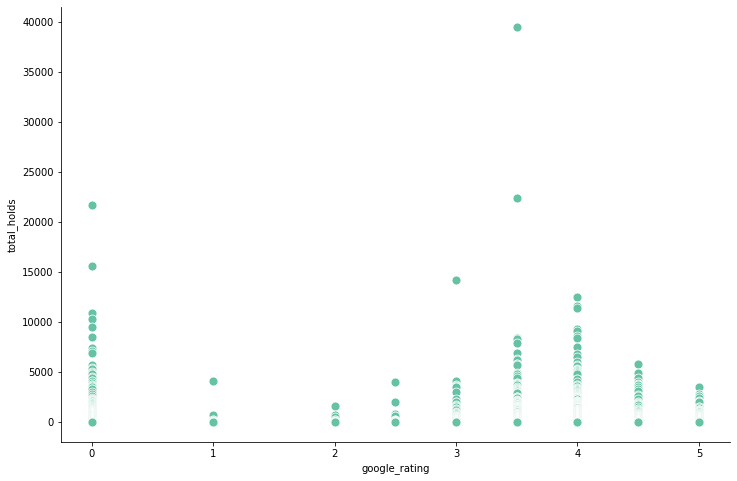

In [39]:
# google rating makes any sense predicting holdings?

sns.scatterplot(x='google_rating', y='total_holds', data=popest, s=80)
sns.despine()

Interesting: it seems that the logic for higher ratings going towards greater holdings numbers stands until rating 4.0 (if we ignore the outliers), an after that it decays which logically we would not expect.

Why? There should be another variable pushing this trend more than the rating. Les try genre

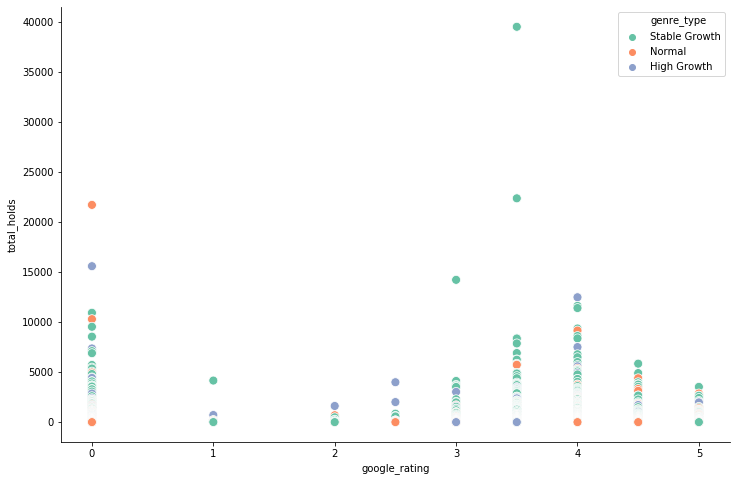

In [40]:
# bringing the genre analysis do the scatter
popest['genre_type'] = ''
# lets use the high and stable lists for genre to classify it
high_growth_genres= high_growth
stable_growth_genres = stable_growth

def classify_genre(genre):
    if genre in high_growth_genres:
        return 'High Growth'
    elif genre in stable_growth_genres:
        return 'Stable Growth'
    else:
        return 'Normal'

popest['genre_type'] = popest.genre.apply(classify_genre)

sns.scatterplot(x='google_rating', y='total_holds', hue='genre_type', data=popest, s=80)
sns.despine()

It is still mixed and doesnt show any relation, it seems that whoever has the most number of stable genres in it would win. So let's ignore the google rating factor.

Lets explore more the top 10 and try to see any patterns here:

#### Big branch factor: do the success of this books has some relation to being featured in bigger branches?

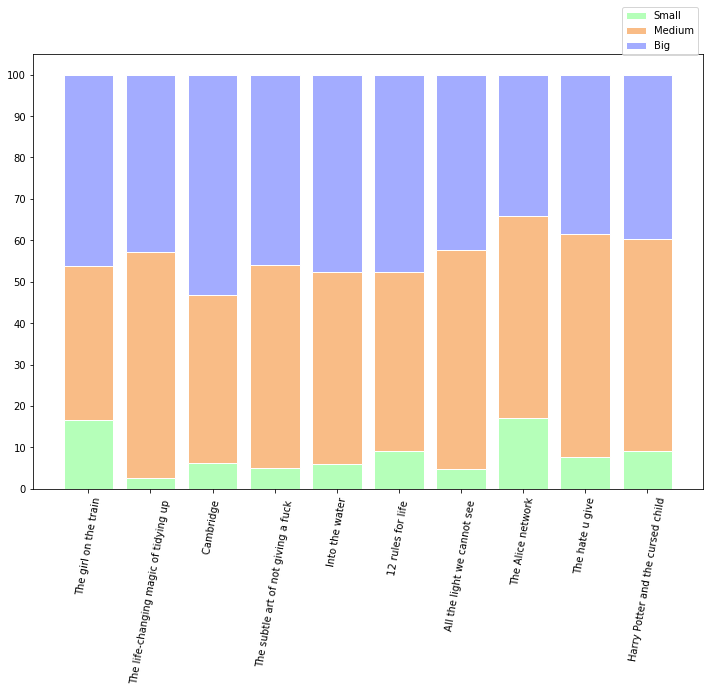

In [41]:
#create graph to see proportion by each branch size in total holdings
pop_brand = pop.groupby([ 'branch_name', 'title']).agg(total_holds=('holds', 'sum'))
pop_brand = pop_brand.reset_index()

#Cleaning branch names to make them smaller
pop_brand['branch_name'] = pop_brand['branch_name'].apply(lambda name: name.replace(' Branch', ''))
pop_brand['branch_name'] = pop_brand['branch_name'].apply(lambda name: name.split(' (')[0])

#lets use rank_dict built for the genre analysis
pop_brand['branch_size_rank'] = pop_brand.branch_name.apply(lambda b: rank_dict[b] )

#let's create levels for the size_rank
# >100k , Big - 50<x<100 - Medium, 50<x Small
def size_type(rank):
    if rank >= 19:
        return 'Big'
    elif rank <= 8:
        return 'Small'
    else:
        return 'Medium'

pop_brand['size_type'] = pop_brand.branch_size_rank.apply(size_type)

#grouping for the graph
pop_brand_g = pop_brand.groupby(['title', 'size_type']).agg(tholds=('total_holds', 'sum'))

#getting the top10list
top10pop = popest.reset_index().loc[:9,'title'].tolist()
toptitles = popest.reset_index().title.unique().tolist()
types = ['Big', 'Small', 'Medium']

#creating the % columns
pop_brand_g['%holds'] = 0
pop_brand_g = pop_brand_g.reset_index('size_type')

for title in toptitles:
    try:
        total = pop_brand_g.loc[title,'tholds'].sum()
        pop_brand_g.loc[title, '%holds'] = (pop_brand_g.loc[title, 'tholds'] / total) * 100
    except IndexError:
        pop_brand_g.loc[title, 'tholds'] = 0 
        pop_brand_g.loc[title, '%holds'] = 0

pop_brand_g = pop_brand_g.reset_index()
pop_graph = pop_brand_g[pop_brand_g.title.isin(top10pop)]
r = list(range(10))

#fixing title names
top10books = [tit.split(':')[0] for tit in top10pop]
top10books = [tit.split('IELTS')[0] for tit in top10books]
top10books = [tit.split('.')[0] for tit in top10books]

#ploting the stacked bar graph
bar_colors = ['#b5ffb9', '#f9bc86', '#a3acff']
graphS = pop_graph[pop_graph.size_type=='Small']
graphM = pop_graph[pop_graph.size_type=='Medium']
graphB = pop_graph[pop_graph.size_type=='Big']


Sbottom = list(graphS['%holds'].values)
Mbottom = list(graphM['%holds'].values)
Bbottom = list(graphB['%holds'].values)
final_bottom = [s+m for s,m in zip(Sbottom,Mbottom)]

plt.bar(r,list(graphS['%holds'].values), color='#b5ffb9', edgecolor='white', label='Small')
plt.bar(r,list(graphM['%holds'].values), bottom=Sbottom, color='#f9bc86', edgecolor='white', label='Medium')
plt.bar(r,list(graphB['%holds'].values), bottom=final_bottom, color='#a3acff', edgecolor='white', label='Big')

plt.xticks(r,tuple(top10books), rotation=80)
plt.yticks(list(range(101))[::10])
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.12))

In [76]:
#create dataframe for heatmap with book rank in the branch by year
pop_rank = pop.groupby(['hold_year', 'branch_name', 'title']).agg(total_holds=('holds', 'sum'))
pop_rank = pop_rank.reset_index('title').sort_values(['hold_year','branch_name', 'total_holds'] ,ascending=False)

rank_branches = pop_rank.reset_index().branch_name.unique().tolist()
rank_years = [2015, 2016, 2017, 2018, 2019]

#adding ranking columns
pop_rank['%holds'] = 0
#pop_rank.loc[(2019, 'Woodcroft Branch'),'total_holds']
for year in rank_years:
    for branch in rank_branches:
        try:
            total = pop_rank.loc[(year,branch),'total_holds'].sum()
            pop_rank.loc[(year,branch), '%holds'] = (pop_rank.loc[(year,branch), 'total_holds'] / total) * 100
        except KeyError:
            continue

pop_rank = pop_rank.reset_index()

# Simplifying branch names
pop_rank['branch_name'] = pop_rank['branch_name'].apply(lambda name: name.replace(' Branch', ''))
pop_rank['branch_name'] = pop_rank['branch_name'].apply(lambda name: name.split(' (')[0])

#Lets bring size rank to build the further heatmaps using rank_dict as above
pop_rank['branch_size_rank'] = pop_rank.branch_name.apply(lambda b: rank_dict[b])

#Creating heamap branch labels
pop_rank['branch_labels'] = pop_rank.branch_name.apply(lambda b: 'Rank:{} - {}'.format(rank_dict[b], b))
            
pop_rank.head() #just testing

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:1761: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2857: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning:

indexing past lexsort depth may impact performance.



,hold_year,branch_name,title,total_holds,%holds,branch_size_rank,branch_labels
0,2019,Woodcroft,The huntress : a novel,199,16.514523,17,Rank:17 - Woodcroft
1,2019,Woodcroft,"The woo woo : how I survived ice hockey, drug ...",172,14.273859,17,Rank:17 - Woodcroft
2,2019,Woodcroft,The hate u give,136,11.286307,17,Rank:17 - Woodcroft
3,2019,Woodcroft,A good wife : escaping the life I never chose,122,10.124481,17,Rank:17 - Woodcroft
4,2019,Woodcroft,Brother,110,9.128631,17,Rank:17 - Woodcroft


In [77]:
#create heatmap with book rank for the top 10 all time in the branch by year

@interact
def generate_heatsns(title = top10pop):

    heater = pop_rank[pop_rank.title==title]
    heater_piv= heater.pivot_table(index=['branch_size_rank', 'branch_labels'], 
                                   values='%holds', columns='hold_year')
    heater_piv= heater_piv.fillna(0).sort_values('branch_size_rank', ascending=False)
    heater_piv = heater_piv.reset_index('branch_size_rank').drop('branch_size_rank', axis=1)

    plt.title('Book Holding Ranking by Branch by Year')
    
    return sns.heatmap(heater_piv,cmap="YlGnBu", annot=True)

interactive(children=(Dropdown(description='title', options=('The girl on the train', 'The life-changing magic…

In [80]:
#Building dataset for the lineplots

#getting release years
rleaseDt = data.loc[:,['title', 'publishing_Date']].drop_duplicates('title')

#merging with last dt 
pop_rel = pop_rank.merge(rleaseDt, how='left', on='title')

pop_rel.head()

,hold_year,branch_name,title,total_holds,%holds,branch_size_rank,branch_labels,publishing_Date
0,2019,Woodcroft,The huntress : a novel,199,16.514523,17,Rank:17 - Woodcroft,2019.0
1,2019,Woodcroft,"The woo woo : how I survived ice hockey, drug ...",172,14.273859,17,Rank:17 - Woodcroft,2018.0
2,2019,Woodcroft,The hate u give,136,11.286307,17,Rank:17 - Woodcroft,2017.0
3,2019,Woodcroft,A good wife : escaping the life I never chose,122,10.124481,17,Rank:17 - Woodcroft,2019.0
4,2019,Woodcroft,Brother,110,9.128631,17,Rank:17 - Woodcroft,2018.0


In [175]:
#fixing mannually to wrong publishing years
pop_rel = pop_rel.set_index('title')
pop_rel.loc['Into the water', 'publishing_Date'] = 2017.0
pop_rel.loc['The Alice network', 'publishing_Date'] = 2017.0
pop_rel = pop_rel.reset_index()

@interact
def generate_stripp_pyear(title=top10pop):
    rel_plotDt = pop_rel[pop_rel.title == title ]

    splot = sns.stripplot(x='hold_year', y='%holds', hue='branch_size_rank',palette='Blues', 
                          data=rel_plotDt, size=12)

    #annotation for publishing year
    publish_year = int(rel_plotDt.iloc[1,7])
    print(rel_plotDt.iloc[1,7])
    ymin, ymax = splot.get_ylim()
    xmin, xmax = splot.get_xlim()
    xcoords, xtexts = plt.xticks()[0], plt.xticks()[1]
    xaxis_dict= {year.get_text():coord for year,coord in zip(xtexts,xcoords)}

    print(publish_year)
    if publish_year >= 2015:
        splot.text(xaxis_dict[str(publish_year)], ymax, "Publishing Year", horizontalalignment='center', 
                size=12, color='red', weight='semibold')
    else:
        splot.text(xmax, ymax, "Published in {}".format(publish_year), 
                   horizontalalignment='center', size=12, color='blue', weight='semibold')
        


    sns.despine()
    plt.legend(bbox_to_anchor=(1.13, 1), title='Branch Size Index')
    
    return splot

interactive(children=(Dropdown(description='title', options=('The girl on the train', 'The life-changing magic…